In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Unzip dataset
!unzip "/content/Chicken.zip" -d "/content/dataset"

In [5]:
# Data format;
# Chicken
#   --> train
#         ->ClassName1
#               - imageX.jpg(or png)
#         ->ClassName2
#               - imageY.jpg(or png)
#   --> val
#         same as train
#   
#   --> classes.txt
#   --> test(optional)
#         same as train


data_dir = '/content/dataset/Chicken'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [6]:
dataset_sizes

{'train': 914, 'val': 264}

In [7]:
class_names

['Ataks', 'Brahma', 'Ligorin', 'Lohman Brown', 'Sussex']

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

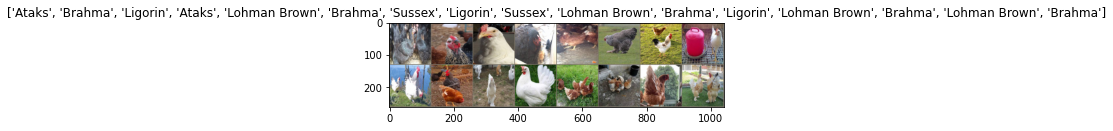

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                            epoch_loss,
                                                            epoch_acc))
            else:
                model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                            epoch_loss,
                                                            epoch_acc))
                print("\n")
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.6 MB/s eta 0:00:00


In [13]:
import timm

timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [26]:
tl_model = models.vgg19(pretrained=True)

tl_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [27]:
for param in tl_model.parameters():
    param.requires_grad = False

In [28]:
tl_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=5, bias=True), # 5 is number of classes
  )

In [29]:
tl_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tl_model.classifier.parameters())

In [31]:
model_trained = train_model(tl_model, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
train loss: 8.4937, acc: 0.5919
val loss: 0.7314, acc: 0.7992


Epoch 2/5
----------
train loss: 1.2266, acc: 0.7779
val loss: 1.3691, acc: 0.7500


Epoch 3/5
----------
train loss: 1.4317, acc: 0.7702
val loss: 1.5067, acc: 0.7424


Epoch 4/5
----------
train loss: 1.3730, acc: 0.7823
val loss: 0.7788, acc: 0.8068


Epoch 5/5
----------
train loss: 1.0337, acc: 0.8425
val loss: 1.3882, acc: 0.7614




In [32]:
FILE = "model_tl_pytorch.pth"
torch.save(model_trained, FILE)

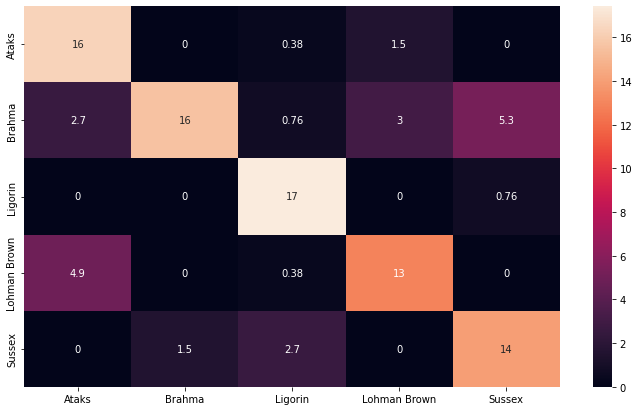

In [33]:
# Confuison Matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

classes = class_names
model = torch.load('model_tl_pytorch.pth') # model path 

y_pred = []
y_true = []

# iterate over val data
for inputs, labels in dataloaders['val']:
    output = model(inputs)  # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)  # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)  # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 100, index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)

plt.show()
